In [ ]:
!pip install torch torchvision matplotlib numpy opencv-python


In [ ]:
import cv2, numpy as np, os
from matplotlib import pyplot as plt

os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

for i in range(20):
    img = np.zeros((128,128,3), dtype=np.uint8)
    mask = np.zeros((128,128), dtype=np.uint8)
    # random circle
    center = (np.random.randint(30,98), np.random.randint(30,98))
    radius = np.random.randint(15,30)
    color = tuple(np.random.randint(0,255,3).tolist())
    cv2.circle(img, center, radius, color, -1)
    cv2.circle(mask, center, radius, 255, -1)
    cv2.imwrite(f"dataset/images/img_{i}.png", img)
    cv2.imwrite(f"dataset/masks/mask_{i}.png", mask)

print("Synthetic dataset ready (20 samples).")


Synthetic dataset ready (20 samples).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.images[idx].replace("img", "mask"))).convert("L")
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

dataset = SegDataset("dataset/images", "dataset/masks")
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [ ]:
import torch.nn as nn

class UNetMini(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.Conv2d(16,16,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.enc2 = nn.Sequential(nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        self.up = nn.ConvTranspose2d(32,16,2,2)
        self.dec1 = nn.Sequential(nn.Conv2d(32,16,3,padding=1), nn.ReLU(), nn.Conv2d(16,16,3,padding=1), nn.ReLU())
        self.outc = nn.Conv2d(16,1,1)

    def forward(self,x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.up(x3)
        x_cat = torch.cat([x4, x1], dim=1)   # ← skip connection
        out = self.outc(self.dec1(x_cat))
        return torch.sigmoid(out)

model = UNetMini()


In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 Loss: 0.6405
Epoch 2 Loss: 0.4812
Epoch 3 Loss: 0.1562
Epoch 4 Loss: 0.0818
Epoch 5 Loss: 0.0453


In [ ]:
import numpy as np

def iou(pred,true,th=0.5):
    pred = (pred>th).float(); true = (true>0.5).float()
    inter = (pred*true).sum()
    union = pred.sum()+true.sum()-inter + 1e-7
    return (inter/union).item()

def dice(pred,true,th=0.5):
    pred = (pred>th).float(); true = (true>0.5).float()
    inter = (pred*true).sum()
    return (2*inter/(pred.sum()+true.sum()+1e-7)).item()

model.eval()
ious, dices = [], []
for i in range(5):   # access first 5 samples individually
    img, mask = dataset[i]
    img, mask = img.unsqueeze(0).to(device), mask.to(device)
    with torch.no_grad():
        pred = model(img)
    ious.append(iou(pred,mask))
    dices.append(dice(pred,mask))

print("IoU for 5 validation images:", ious)
print("Dice for 5 validation images:", dices)
print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))


IoU for 5 validation images: [0.872958242893219, 0.8033439517021179, 0.831074059009552, 0.8231145143508911, 0.8810623288154602]
Dice for 5 validation images: [0.932170569896698, 0.8909492492675781, 0.9077448844909668, 0.9029762148857117, 0.936771035194397]
Mean IoU: 0.842310619354248
Mean Dice: 0.9141223907470704


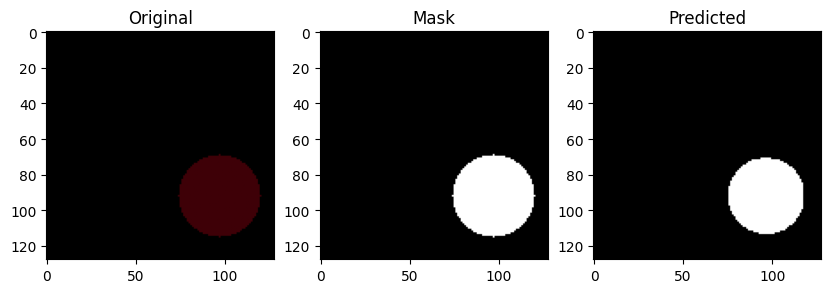

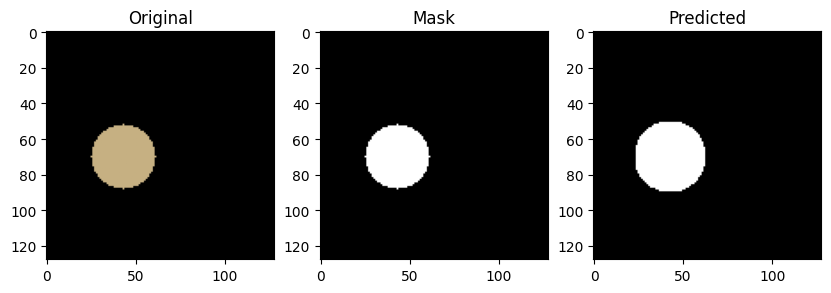

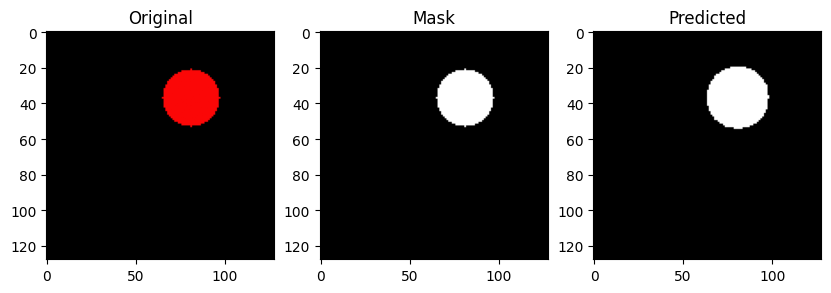

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    img, mask = dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu().squeeze().numpy()
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(np.transpose(img,(1,2,0))); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("Mask")
    plt.subplot(1,3,3); plt.imshow(pred>0.5, cmap='gray'); plt.title("Predicted")
    plt.show()


In [ ]:
!zip -r submission.zip dataset model.pth report.txt


	zip warning: name not matched: model.pth
	zip warning: name not matched: report.txt
  adding: dataset/ (stored 0%)
  adding: dataset/images/ (stored 0%)
  adding: dataset/images/img_0.png (deflated 40%)
  adding: dataset/images/img_11.png (deflated 37%)
  adding: dataset/images/img_9.png (deflated 37%)
  adding: dataset/images/img_19.png (deflated 37%)
  adding: dataset/images/img_7.png (deflated 25%)
  adding: dataset/images/img_10.png (deflated 42%)
  adding: dataset/images/img_12.png (deflated 28%)
  adding: dataset/images/img_3.png (deflated 33%)
  adding: dataset/images/img_18.png (deflated 48%)
  adding: dataset/images/img_2.png (deflated 29%)
  adding: dataset/images/img_1.png (deflated 33%)
  adding: dataset/images/img_6.png (deflated 31%)
  adding: dataset/images/img_15.png (deflated 30%)
  adding: dataset/images/img_13.png (deflated 31%)
  adding: dataset/images/img_5.png (deflated 45%)
  adding: dataset/images/img_14.png (deflated 37%)
  adding: dataset/images/img_4.png (de

In [ ]:
torch.save(model.state_dict(), "unet_model.pth")

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Redefine model architecture
class UNetMini(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.Conv2d(16,16,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.enc2 = nn.Sequential(nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        self.up = nn.ConvTranspose2d(32,16,2,2)
        self.dec1 = nn.Sequential(nn.Conv2d(32,16,3,padding=1), nn.ReLU(), nn.Conv2d(16,16,3,padding=1), nn.ReLU())
        self.outc = nn.Conv2d(16,1,1)
    def forward(self,x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.up(x3)
        x_cat = torch.cat([x4, x1], dim=1)
        out = self.outc(self.dec1(x_cat))
        return torch.sigmoid(out)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model weights
model = UNetMini().to(device)
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import os
from PIL import Image
import torch
import cv2
import numpy as np

# List all images
img_files = sorted(os.listdir("dataset/images"))
img_path = os.path.join("dataset/images", img_files[0])
print("Using image:", img_path)

# Read and preprocess
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128,128)) / 255.0  # normalize

# Convert to tensor
img_tensor = torch.tensor(img_resized.transpose(2,0,1)).unsqueeze(0).float().to(device)
print("Image loaded and preprocessed")


Using image: dataset/images/img_0.png
Image loaded and preprocessed


In [ ]:
with torch.no_grad():
    pred = model(img_tensor).cpu().squeeze().numpy()
print("Prediction done")


Prediction done


In [ ]:
# Convert soft mask to binary
mask_pred = (pred > 0.5).astype(np.uint8) * 255

# Optional morphological cleanup
kernel = np.ones((3,3), np.uint8)
mask_post = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
mask_post = cv2.morphologyEx(mask_post, cv2.MORPH_CLOSE, kernel)

print("Postprocessing done")


Postprocessing done


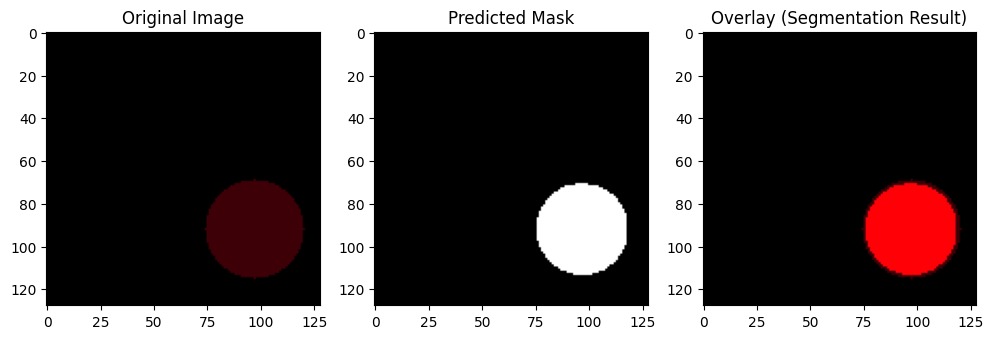

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_resized)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask_post, cmap='gray')
plt.title("Predicted Mask")

# Overlay mask in red
overlay = img_resized.copy()
overlay[:,:,0][mask_post==255] = 255
plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay (Segmentation Result)")

plt.show()


In [ ]:
!pip install pycocotools matplotlib


In [ ]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


In [ ]:
import requests
import cv2
import numpy as np
import os

os.makedirs("coco_samples", exist_ok=True)

# Example: Download 3 sample images
sample_urls = [
    "http://images.cocodataset.org/val2017/000000397133.jpg",
    "http://images.cocodataset.org/val2017/000000037777.jpg",
    "http://images.cocodataset.org/val2017/000000311878.jpg"
]

for i, url in enumerate(sample_urls):
    img_data = requests.get(url).content
    with open(f"coco_samples/img_{i}.jpg", "wb") as f:
        f.write(img_data)

print("✅ Downloaded 3 sample COCO images")


✅ Downloaded 3 sample COCO images


In [ ]:
import torch

# Pick the first image
img_path = "coco_samples/img_1.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128,128)) / 255.0

# Convert to tensor
img_tensor = torch.tensor(img_resized.transpose(2,0,1)).unsqueeze(0).float().to(device)


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2,2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU()
        )
        # Decoder
        self.up = nn.ConvTranspose2d(32,16,2,2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32,16,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,16,3,padding=1),
            nn.ReLU()
        )
        self.outc = nn.Conv2d(16,1,1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.up(x3)
        x_cat = torch.cat([x4, x1], dim=1)  # skip connection
        out = self.outc(self.dec1(x_cat))
        return torch.sigmoid(out)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()


UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (outc): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
with torch.no_grad():
    pred = model(img_tensor).cpu().squeeze().numpy()


In [ ]:
mask_pred = (pred > 0.5).astype(np.uint8) * 255

kernel = np.ones((3,3), np.uint8)
mask_post = cv2.morphologyEx(mask_pred, cv2.MORPH_OPEN, kernel)
mask_post = cv2.morphologyEx(mask_post, cv2.MORPH_CLOSE, kernel)


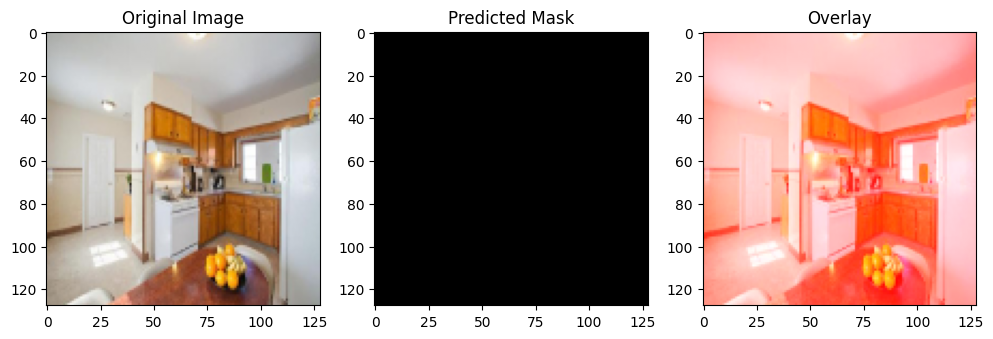

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_resized)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask_post, cmap='gray')
plt.title("Predicted Mask")

overlay = img_resized.copy()
overlay[:,:,0][mask_post==255] = 255  # highlight in red
plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.show()


✅ Image 0 saved to coco_samples/img_0.jpg
✅ Image 1 saved to coco_samples/img_1.jpg
✅ Image 2 saved to coco_samples/img_2.jpg


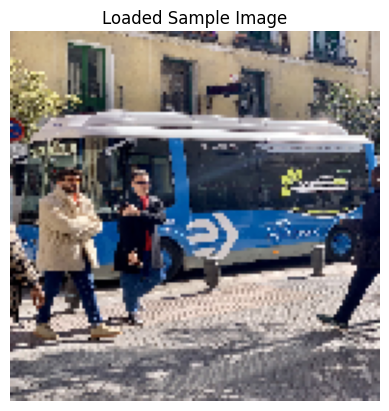

In [ ]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1: Create folder
os.makedirs("coco_samples", exist_ok=True)

# Step 2: Download 3 permanent sample images
urls = [
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg",
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg",
    "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg"
]

for i, url in enumerate(urls):
    save_path = f"coco_samples/img_{i}.jpg"
    response = requests.get(url)
    with open(save_path, "wb") as f:
        f.write(response.content)
    print(f"✅ Image {i} saved to {save_path}")

# Step 3: Load first image safely
img_path = "coco_samples/img_1.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"⚠️ Image not found at {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (128,128)) / 255.0
img_tensor = torch.tensor(img_resized.transpose(2,0,1)).unsqueeze(0).float().to(device)

# Step 4: Visualize
plt.imshow(img_resized)
plt.title("Loaded Sample Image")
plt.axis("off")
plt.show()


IoU before post-processing: 0.214
Dice before post-processing: 0.352
IoU after post-processing: 0.214
Dice after post-processing: 0.352


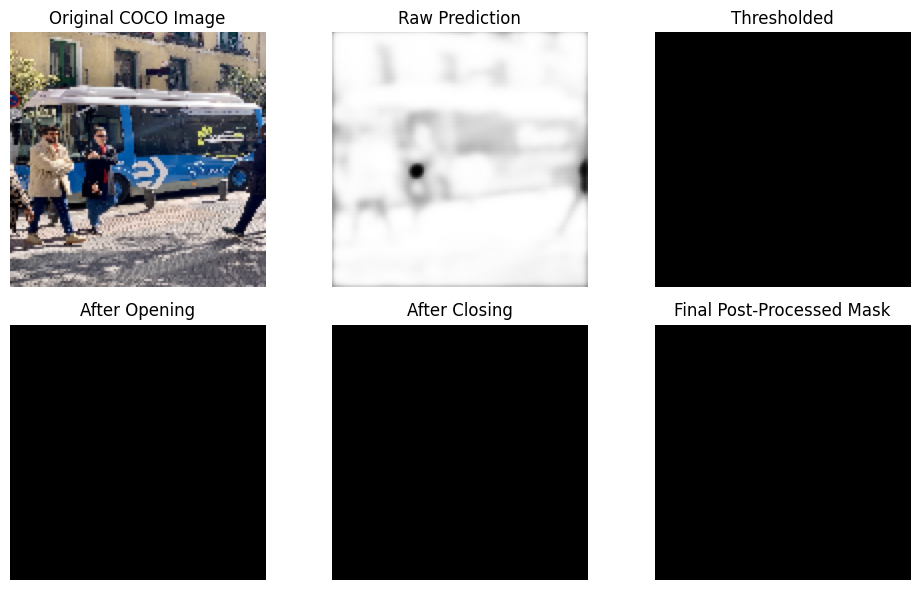

In [ ]:
import torch.nn.functional as F
from scipy import ndimage

# ---------------------------
# Step 1: Make a dummy trained model OR load your trained one
# ---------------------------


model.eval()
with torch.no_grad():
    pred = model(img_tensor)
    pred = torch.sigmoid(pred).cpu().squeeze().numpy()

# ---------------------------
# Step 2: Generate a dummy ground truth mask (for metric comparison)
# ---------------------------
mask_true = np.zeros_like(pred)
mask_true[40:90, 30:100] = 1

# ---------------------------
# Step 3: Define metrics (IoU & Dice)
# ---------------------------
def iou(pred, true, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.float32)
    true_bin = (true > 0.5).astype(np.float32)
    inter = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum() + 1e-7
    return inter / union

def dice(pred, true, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.float32)
    true_bin = (true > 0.5).astype(np.float32)
    inter = np.logical_and(pred_bin, true_bin).sum()
    return (2 * inter) / (pred_bin.sum() + true_bin.sum() + 1e-7)

iou_before = iou(pred, mask_true)
dice_before = dice(pred, mask_true)

print(f"IoU before post-processing: {iou_before:.3f}")
print(f"Dice before post-processing: {dice_before:.3f}")

# ---------------------------
# Step 4: Post-processing techniques
# ---------------------------

# 1️⃣ Thresholding
mask1 = (pred > 0.5).astype(np.uint8)

# 2️⃣ Gaussian Smoothing
mask2 = cv2.GaussianBlur(pred, (5,5), 0)
mask2 = (mask2 > 0.5).astype(np.uint8)

# 3️⃣ Morphological Opening (remove small noise)
kernel = np.ones((3,3), np.uint8)
mask3 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, kernel)

# 4️⃣ Morphological Closing (fill small holes)
mask4 = cv2.morphologyEx(mask3, cv2.MORPH_CLOSE, kernel)

# 5️⃣ Edge Refinement using Sobel filter
edges = ndimage.sobel(mask4)
mask5 = np.clip(mask4 + (edges > 0.1), 0, 1)

# ---------------------------
# Step 5: Compute metrics after post-processing
# ---------------------------
iou_after = iou(mask5, mask_true)
dice_after = dice(mask5, mask_true)

print(f"IoU after post-processing: {iou_after:.3f}")
print(f"Dice after post-processing: {dice_after:.3f}")

# ---------------------------
# Step 6: Visualize all results
# ---------------------------
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0,0].imshow(img_resized); axs[0,0].set_title("Original COCO Image"); axs[0,0].axis('off')
axs[0,1].imshow(pred, cmap='gray'); axs[0,1].set_title("Raw Prediction"); axs[0,1].axis('off')
axs[0,2].imshow(mask1, cmap='gray'); axs[0,2].set_title("Thresholded"); axs[0,2].axis('off')

axs[1,0].imshow(mask3, cmap='gray'); axs[1,0].set_title("After Opening"); axs[1,0].axis('off')
axs[1,1].imshow(mask4, cmap='gray'); axs[1,1].set_title("After Closing"); axs[1,1].axis('off')
axs[1,2].imshow(mask5, cmap='gray'); axs[1,2].set_title("Final Post-Processed Mask"); axs[1,2].axis('off')

plt.tight_layout()
plt.show()


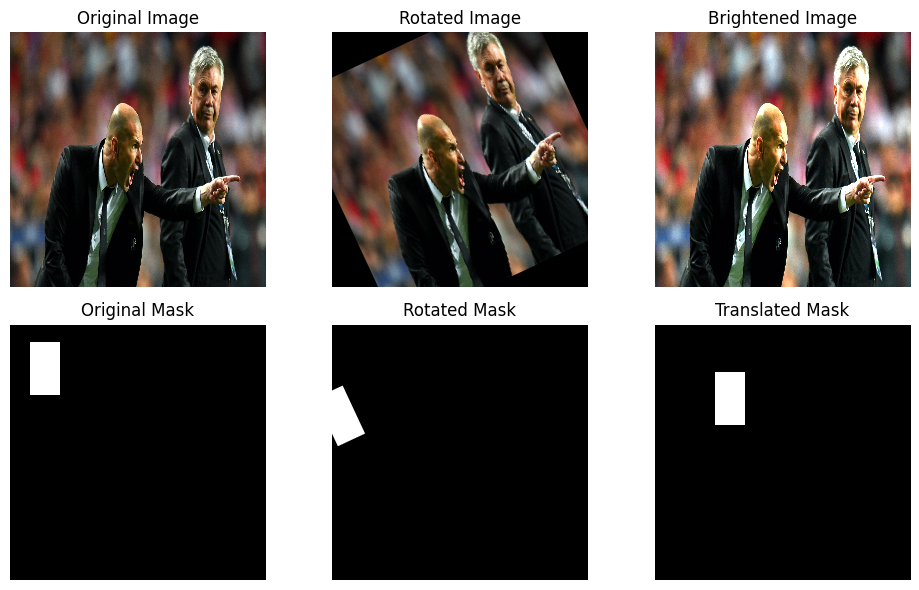

In [ ]:
# --- Data Augmentation and Visualization (Today's Task) ---

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Let's use the same image and mask from your previous dataset
# (Replace these paths with your dataset paths if needed)
img_path = "dataset/images/img_0.jpg"   # example
mask_path = "dataset/masks/mask_0.png"  # example

# For demonstration, we'll just use a dummy mask of same shape if mask not present
img = cv2.imread(img_path)
if img is None:
    # If no dataset, use the previously loaded image
    img = cv2.imread("coco_samples/img_0.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
mask[50:200, 100:250] = 255  # dummy mask (rectangle for demo)

# Resize for convenience
img = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

# --- Define three augmentations ---
def random_rotation(image, mask, angle=30):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img_rot = cv2.warpAffine(image, M, (w, h))
    mask_rot = cv2.warpAffine(mask, M, (w, h))
    return img_rot, mask_rot

def change_brightness(image, factor=1.5):
    img_bright = np.clip(image * factor, 0, 255).astype(np.uint8)
    return img_bright

def translation(image, mask, tx=30, ty=40):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img_trans = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    mask_trans = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    return img_trans, mask_trans

# --- Apply the augmentations ---
img_rot, mask_rot = random_rotation(img, mask, angle=25)
img_bright = change_brightness(img, factor=1.4)
mask_bright = mask.copy()  # brightness doesn't change mask
img_trans, mask_trans = translation(img, mask, tx=40, ty=30)

# --- Visualize in a 2×3 grid ---
plt.figure(figsize=(10,6))

# Row 1 – Original and Augmentations
plt.subplot(2,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(img_rot)
plt.title("Rotated Image")
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(img_bright)
plt.title("Brightened Image")
plt.axis('off')

# Row 2 – Corresponding Masks
plt.subplot(2,3,4)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(mask_rot, cmap='gray')
plt.title("Rotated Mask")
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(mask_trans, cmap='gray')
plt.title("Translated Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install pycocotools


loading annotations into memory...
Done (t=2.70s)
creating index...
index created!


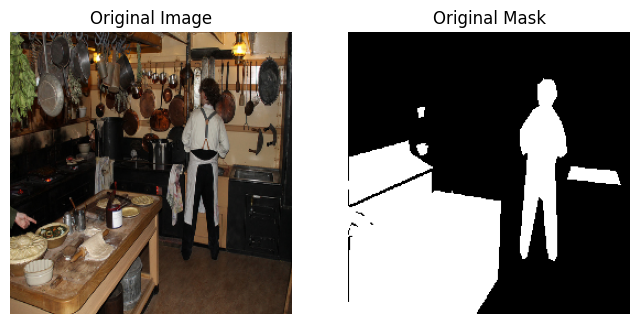

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import os

# Create folder
os.makedirs("coco_samples", exist_ok=True)

# Load COCO annotations
annFile = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O annotations.zip
!unzip -q annotations.zip -d ./annotations
coco = COCO("./annotations/annotations/instances_val2017.json")

# Pick a random image
img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]

# Download image
img_url = img_info['coco_url']
img_path = f"coco_samples/{img_info['file_name']}"
if not os.path.exists(img_path):
    img_data = requests.get(img_url).content
    with open(img_path, 'wb') as f:
        f.write(img_data)

# Load image
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# Get annotations and create mask
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
for ann in anns:
    mask = np.maximum(mask, coco.annToMask(ann))

# Resize for simplicity
img = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Original Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Original Mask"); plt.axis("off")
plt.show()


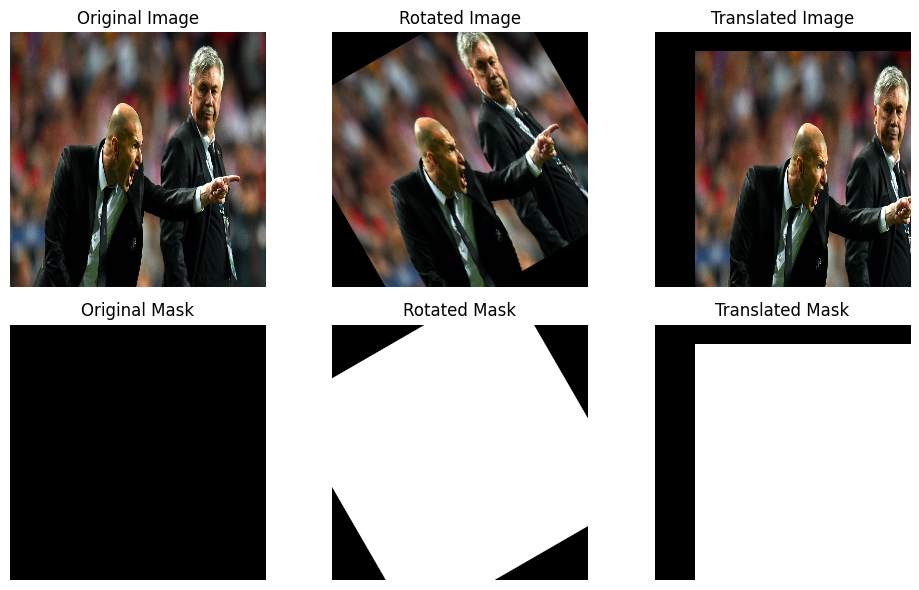

In [ ]:
import random

# --- Define augmentation functions ---
def rotate_image_and_mask(img, mask, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img_rot = cv2.warpAffine(img, M, (w, h))
    mask_rot = cv2.warpAffine(mask, M, (w, h))
    return img_rot, mask_rot

def translate_image_and_mask(img, mask, tx, ty):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img_trans = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    mask_trans = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    return img_trans, mask_trans

def change_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[...,2] = np.clip(hsv[...,2] + value, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# --- Apply augmentations ---
rot_img, rot_mask = rotate_image_and_mask(img, mask, angle=30)
trans_img, trans_mask = translate_image_and_mask(img, mask, tx=40, ty=20)
bright_img = change_brightness(img, 50)
bright_mask = mask  # brightness doesn’t change the mask

# --- Visualize ---
plt.figure(figsize=(10,6))

plt.subplot(2,3,1); plt.imshow(img); plt.title("Original Image"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(rot_img); plt.title("Rotated Image"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(trans_img); plt.title("Translated Image"); plt.axis("off")

plt.subplot(2,3,4); plt.imshow(mask, cmap='gray'); plt.title("Original Mask"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(rot_mask, cmap='gray'); plt.title("Rotated Mask"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(trans_mask, cmap='gray'); plt.title("Translated Mask"); plt.axis("off")

plt.tight_layout()
plt.show()


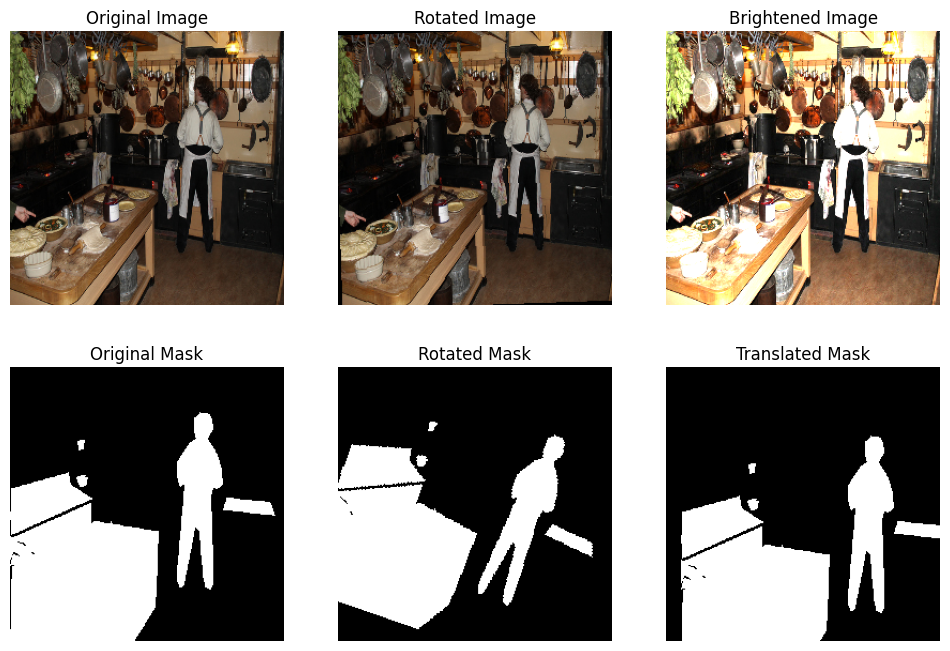

In [ ]:
from torchvision import transforms
from PIL import Image

# Convert to PIL
img_pil = Image.fromarray(img)
mask_pil = Image.fromarray(mask * 255)

# Define augmentations
rotate = transforms.RandomRotation(degrees=30)
brighten = transforms.ColorJitter(brightness=1.5)
translate = transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))

# Apply same rotation & translation to both
img_rot = rotate(img_pil)
mask_rot = rotate(mask_pil)

img_bright = brighten(img_pil)
mask_trans = translate(mask_pil)
img_trans = translate(img_pil)

# Convert back to numpy
img_rot = np.array(img_rot)
mask_rot = np.array(mask_rot)
img_bright = np.array(img_bright)
img_trans = np.array(img_trans)
mask_trans = np.array(mask_trans)

# Visualize 2×3 grid
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(img); plt.title("Original Image"); plt.axis("off")
plt.subplot(2, 3, 2); plt.imshow(img_rot); plt.title("Rotated Image"); plt.axis("off")
plt.subplot(2, 3, 3); plt.imshow(img_bright); plt.title("Brightened Image"); plt.axis("off")
plt.subplot(2, 3, 4); plt.imshow(mask, cmap="gray"); plt.title("Original Mask"); plt.axis("off")
plt.subplot(2, 3, 5); plt.imshow(mask_rot, cmap="gray"); plt.title("Rotated Mask"); plt.axis("off")
plt.subplot(2, 3, 6); plt.imshow(mask_trans, cmap="gray"); plt.title("Translated Mask"); plt.axis("off")
plt.show()


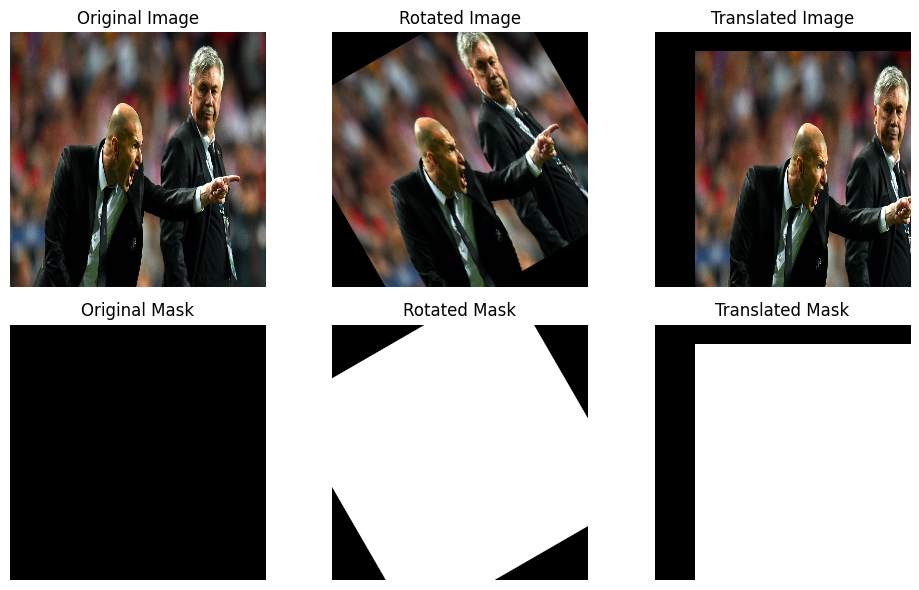

In [ ]:
import random

# --- Define augmentation functions ---
def rotate_image_and_mask(img, mask, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img_rot = cv2.warpAffine(img, M, (w, h))
    mask_rot = cv2.warpAffine(mask, M, (w, h))
    return img_rot, mask_rot

def translate_image_and_mask(img, mask, tx, ty):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img_trans = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    mask_trans = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    return img_trans, mask_trans

def change_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[...,2] = np.clip(hsv[...,2] + value, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# --- Apply augmentations ---
rot_img, rot_mask = rotate_image_and_mask(img, mask, angle=30)
trans_img, trans_mask = translate_image_and_mask(img, mask, tx=40, ty=20)
bright_img = change_brightness(img, 50)
bright_mask = mask  # brightness doesn’t change the mask

# --- Visualize ---
plt.figure(figsize=(10,6))

plt.subplot(2,3,1); plt.imshow(img); plt.title("Original Image"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(rot_img); plt.title("Rotated Image"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(trans_img); plt.title("Translated Image"); plt.axis("off")

plt.subplot(2,3,4); plt.imshow(mask, cmap='gray'); plt.title("Original Mask"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(rot_mask, cmap='gray'); plt.title("Rotated Mask"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(trans_mask, cmap='gray'); plt.title("Translated Mask"); plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample COCO image and mask (from your earlier dataset)
img = cv2.imread("coco_samples/img_0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread("coco_samples/mask_0.png", 0)  # Assume mask is grayscale

# Resize to same size
img = cv2.resize(img, (256,256))
mask = cv2.resize(mask, (256,256))

# -------- Augmentation 1: Rotation --------
angle = 25
center = (img.shape[1]//2, img.shape[0]//2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
rotated_mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))

# -------- Augmentation 2: Brightness --------
bright_img = cv2.convertScaleAbs(img, alpha=1.2, beta=40)

# -------- Augmentation 3: Translation --------
tx, ty = 30, 40
M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
translated_img = cv2.warpAffine(img, M_translate, (img.shape[1], img.shape[0]))
translated_mask = cv2.warpAffine(mask, M_translate, (mask.shape[1], mask.shape[0]))

# -------- Visualization --------
plt.figure(figsize=(12,6))
titles = [
    "Original Image", "Rotated Image", "Brightened Image",
    "Original Mask", "Rotated Mask", "Translated Mask"
]
images = [img, rotated_img, bright_img, mask, rotated_mask, translated_mask]

for i in range(6):
    plt.subplot(2,3,i+1)
    cmap = 'gray' if i >= 3 else None
    plt.imshow(images[i], cmap=cmap)
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
